# Import data and visualize

In [64]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helpers import accuracy_fn
RANDOM_STATE = 42
NUM_FEATURES = 2
NUM_CLASSES = 4

X_blobs, y_blobs = make_blobs(n_samples=1000, 
                              n_features= NUM_FEATURES, 
                              random_state=RANDOM_STATE,
                              cluster_std=1.5,
                              centers= NUM_CLASSES)

# Turn the data into tensors
X_blobs = torch.from_numpy(X_blobs).float()
y_blobs = torch.from_numpy(y_blobs)

# train test split
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(X_blobs,y_blobs,random_state=RANDOM_STATE, test_size=0.2)


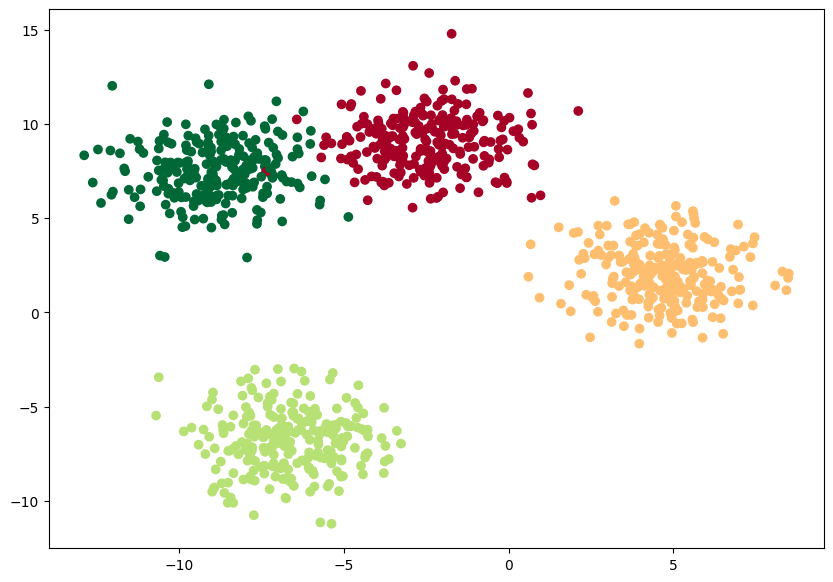

In [65]:
plt.figure(figsize=[10,7])
plt.scatter(x=X_blobs[:,0],y=X_blobs[:,1],c=y_blobs,cmap=plt.cm.RdYlGn)

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model class

In [67]:
class Multi_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=NUM_CLASSES)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)
    

model_1 = Multi_classifier().to(device)

In [68]:
model_1.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.6764,  0.3916],
                      [-0.0216, -0.1600],
                      [-0.3917, -0.6531],
                      [-0.3037,  0.0042],
                      [ 0.4316, -0.2349],
                      [ 0.5849,  0.0945],
                      [-0.5602, -0.0295],
                      [-0.1426,  0.4234],
                      [ 0.0551,  0.0669],
                      [ 0.1923, -0.2979],
                      [-0.5366,  0.3151],
                      [-0.2335, -0.4542],
                      [ 0.5232,  0.4765],
                      [-0.4355, -0.3689],
                      [-0.7026,  0.5436],
                      [-0.2811, -0.4458],
                      [ 0.3330, -0.7019],
                      [ 0.2560, -0.3568],
                      [-0.2261, -0.5361],
                      [-0.2173, -0.1284],
                      [-0.5466, -0.0976],
                      [-0.6268,  0.5686],
                      [ 0.6001,

# Download helper

In [69]:
import requests
from pathlib import Path

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")

with open("helpers.py","wb") as f:
    f.write(request.content)


# Loss and optimizer 

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

# Model Training

In [71]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_blobs_train.to(device))

torch.softmax(y_preds[:20],dim=1)

tensor([[0.2100, 0.2154, 0.2216, 0.3530],
        [0.1900, 0.1889, 0.2592, 0.3620],
        [0.5733, 0.0875, 0.1384, 0.2008],
        [0.4154, 0.1417, 0.2085, 0.2344],
        [0.1939, 0.2065, 0.2748, 0.3248],
        [0.2305, 0.1936, 0.2209, 0.3550],
        [0.1781, 0.1888, 0.2822, 0.3509],
        [0.2215, 0.2228, 0.2250, 0.3307],
        [0.1672, 0.2345, 0.2995, 0.2988],
        [0.1871, 0.1973, 0.2785, 0.3371],
        [0.2194, 0.1826, 0.2157, 0.3823],
        [0.1943, 0.2040, 0.2742, 0.3276],
        [0.1647, 0.2328, 0.3010, 0.3015],
        [0.5526, 0.0788, 0.0997, 0.2690],
        [0.1442, 0.2291, 0.3196, 0.3071],
        [0.4346, 0.1383, 0.1568, 0.2703],
        [0.2142, 0.2221, 0.2195, 0.3442],
        [0.2168, 0.2292, 0.1956, 0.3584],
        [0.1328, 0.2243, 0.3297, 0.3133],
        [0.4102, 0.1267, 0.2296, 0.2335]], device='cuda:0')

In [72]:
epochs = 200

X_blobs_train = X_blobs_train.to(device) 
X_blobs_test = X_blobs_test.to(device)
y_blobs_train = y_blobs_train.to(device)
y_blobs_test = y_blobs_test.to(device)

for epoch in range(epochs):
    
    model_1.train()
    # logits from the model ------> (using sofmax) -----> each class prediction ------> class labels using argmax
    y_logits = model_1(X_blobs_train)
    y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
    y_acc = accuracy_fn(y_true=y_blobs_train,y_pred=y_preds)

    loss = loss_fn(y_logits,y_blobs_train)
    
    optimizer.zero_grad()
    # Back propagation
    loss.backward()

    optimizer.step()
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        y_logits = model_1(X_blobs_test)
        y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_acc = accuracy_fn(y_pred=y_preds,y_true=y_blobs_test)
        test_loss = loss_fn(y_logits,y_blobs_test)

        print(f"epoch : {epoch} | loss={loss:.4f} , accuracy={y_acc:.2f}| test_loss={test_loss:.4f}, test_acc={y_acc:.2f}")


epoch : 0 | loss=1.5351 , accuracy=28.50| test_loss=1.4052, test_acc=28.50
epoch : 1 | loss=1.4268 , accuracy=28.50| test_loss=1.3094, test_acc=28.50
epoch : 2 | loss=1.3368 , accuracy=28.50| test_loss=1.2286, test_acc=28.50
epoch : 3 | loss=1.2597 , accuracy=33.00| test_loss=1.1584, test_acc=33.00
epoch : 4 | loss=1.1918 , accuracy=41.50| test_loss=1.0968, test_acc=41.50
epoch : 5 | loss=1.1315 , accuracy=52.50| test_loss=1.0422, test_acc=52.50
epoch : 6 | loss=1.0773 , accuracy=72.00| test_loss=0.9930, test_acc=72.00
epoch : 7 | loss=1.0282 , accuracy=74.00| test_loss=0.9483, test_acc=74.00
epoch : 8 | loss=0.9832 , accuracy=74.50| test_loss=0.9075, test_acc=74.50
epoch : 9 | loss=0.9420 , accuracy=75.00| test_loss=0.8702, test_acc=75.00
epoch : 10 | loss=0.9039 , accuracy=75.00| test_loss=0.8358, test_acc=75.00
epoch : 11 | loss=0.8686 , accuracy=75.00| test_loss=0.8041, test_acc=75.00
epoch : 12 | loss=0.8360 , accuracy=75.50| test_loss=0.7747, test_acc=75.50
epoch : 13 | loss=0.80

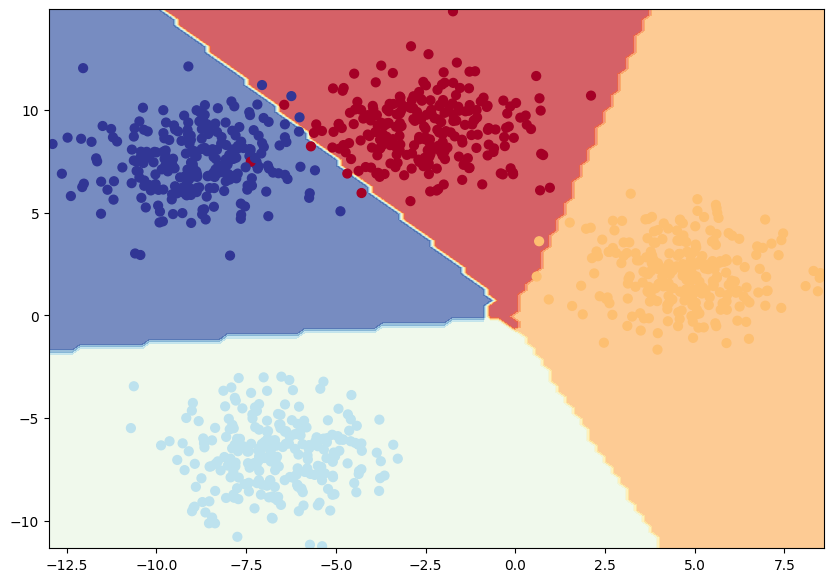

In [75]:
from helpers import plot_decision_boundary

plt.figure(figsize=[10,7])
plot_decision_boundary(model_1,X_blobs,y_blobs)